importing everything here

In [171]:
import pandas as pd
import matplotlib.pyplot as plt
import collections
import pygal
from pygal_maps_world.maps import World
from pygal.style import DefaultStyle
import numpy as np 
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score,mean_squared_error
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
#from sklearn.neighbors import KNeighborsClassifier #not using K nearest
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc, classification_report
from imblearn.over_sampling import SMOTE

Cleaning the Data

In [172]:
#merge articleInfo.csv and authorInfo.csv based on Article number . fill empty cells with zero
author = pd.read_csv('authorInfo.csv')
article = pd.read_csv('articleInfo.csv')

df = article.merge(author, on=["Article No."])
#df.isna().sum()
df = df.fillna(0)
df.isna().sum()
#filling all na cells with 0

Article No.           0
Title                 0
Year                  0
Author Number         0
Key Words             0
Citation              0
Source                0
Abstract              0
Type                  0
Author Name           0
Author Affiliation    0
Country               0
h-index               0
dtype: int64

## Section 1: Python Fundamentals

1. Plot yearly_publication figure  
    x-axis = year  
    y-axis = number of articles published that year

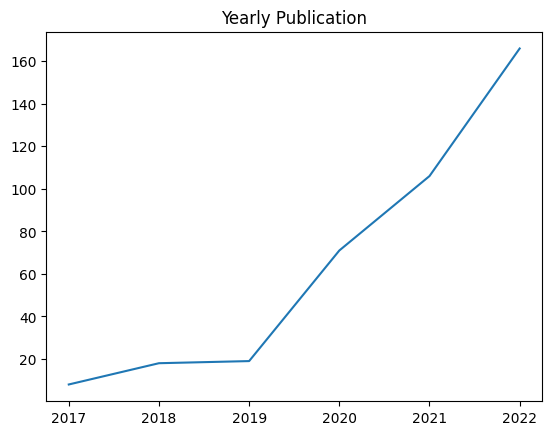

In [173]:
df_ = df.sort_values('Year', ascending = True)
new_df = (df_.groupby('Year').count())

plt.plot(df_['Year'].unique(), new_df['Article No.'])
plt.savefig("yr_art.png")
plt.title("Yearly Publication")
plt.show()

2. Plot yearly_citation figure  
    x-axis = year  
    y-axis = total number of citations during that year

C:\Users\avamc_srsebwe\AppData\Local\Temp\ipykernel_15552\422652743.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  new_df = (df_.groupby('Year').sum())


<function matplotlib.pyplot.show(close=None, block=None)>

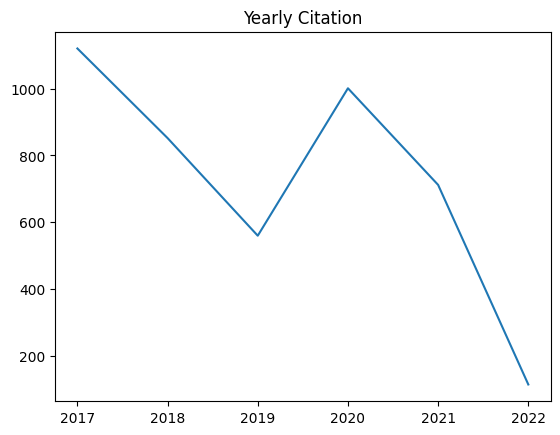

In [174]:
df_ = article.sort_values('Year', ascending = True)
new_df = (df_.groupby('Year').sum())
plt.plot(df_['Year'].unique(), new_df['Citation'])
plt.title("Yearly Citation")
plt.savefig("yr_cit.png")
plt.show

3. Plot figure of the number of publications across countries 

In [175]:
new_df = df[['Country', 'Article No.']]
new_df.loc[df['Country'] == 0] = '' #changing to nothing so we can sort countries alphabetically
new_df = new_df.sort_values('Country')

#print(new_df['Country'].unique()) #seeing list of countries
#fixing typos
new_df.loc[df['Country'] == "Bristol"] = 'United Kingdom'
new_df.loc[df['Country'] == "Chian"] = 'China'
new_df.loc[df['Country'] == "Denamrk"] = 'Denmark'
new_df.loc[df['Country'] == "Denmark "] = 'Denmark'
new_df.loc[df['Country'] == "Chile "] = 'Chile'
new_df.loc[df['Country'] == "Spain "] = 'Spain'
new_df = new_df.sort_values('Country')
#print(new_df['Country'].unique())

#grouping by Country to get number of publications per country
new_df = (new_df.groupby('Country', as_index=False).count())

#manually adding country codes. if more countries, could make csv and match; however, manual is faster in this case since there are no premade csv of these codes to my knowledge
new_df.insert(0, "Country Codes", ['','au','ca', 'cl', 'cn','cy','cz','dk','fr','de','gr','hk','in','ie','il','it','kr','kg','li','my','mx','nz','no','pk','ps','ru','sk','za','es','ch','tw','us','ua','ae','gb'])
new_df = new_df[['Country Codes', 'Article No.']]

world=World(print_labels=True, print_values=True, style=DefaultStyle(value_font_family='googlefont:Raleway',
    value_font_size=30,
    value_colors=('white',)))
world.force_uri_protocal = 'http'

world.add("Publications", dict(zip(new_df['Country Codes'], new_df['Article No.'])))
world.title = "No. of Publications by Country"
world.render_to_file('map.svg')

4. What are top 5 institutions that have the most published articles in this area

In [176]:
new_df = (df.groupby('Author Affiliation', as_index=False).nunique())
new_df = new_df[['Article No.', 'Author Affiliation']]
new_df = new_df.rename(columns={'Article No.':'Number of Publications'})
new_df = new_df.sort_values('Number of Publications', ascending=False)
new_df.head(5)

,Number of Publications,Author Affiliation
115,2,University of Copenhagen
55,2,Malaysia University of Science and Technology
110,2,University of Bristol
28,2,Fudan University
125,2,University of Management and Technology


5. What are top 5 researchers that have the most h-index in this area

In [177]:
new_df = df[['h-index', 'Author Name']]
new_df = new_df.sort_values('h-index', ascending=False)
new_df.head(5)

,h-index,Author Name
117,95.0,Ulrich Trautwein
102,63.0,Nicolas Molinari
130,59.0,George S. Athwal
140,33.0,Maria Luisa Lorusso
147,33.0,Vicente A. González


## Section 2: Regression Analysis

n = 60  
eval system usability of siri for purchasing tickets  
independent vars [ASR_Error, IntentError, Duration, Purchase, Gender]  
dependent var [SUS (usability score)]


In [178]:
#cleaing the data

#using data.csv
df = pd.read_csv('data.csv')
#df.head(10)

#Determine if any values in the data frame are missing
df.isna().sum() # df.isnull().sum also return the number of missing values, you can use either of them]
df = df.fillna(0) # fill any missing values with 0

#nothing is categorical

#use pandas built-in function to compute pair-wise correlations
 #pearson: standard correlation coefficient
df.corr(method='pearson')['SUS'].sort_values() 

Intent_Error   -0.693675
ASR_Error      -0.662405
Duration       -0.006631
Gender          0.111523
Purchase        0.661931
SUS             1.000000
Name: SUS, dtype: float64

 Purchase our independent var has moderate positive correlation with  SUS our dependent var.

Intent_Error and ASR_Error have moderate negative correlation with SUS our dependent var.

C:\Users\avamc_srsebwe\AppData\Local\Temp\ipykernel_15552\4244522798.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df['SUS'], palette='bright')


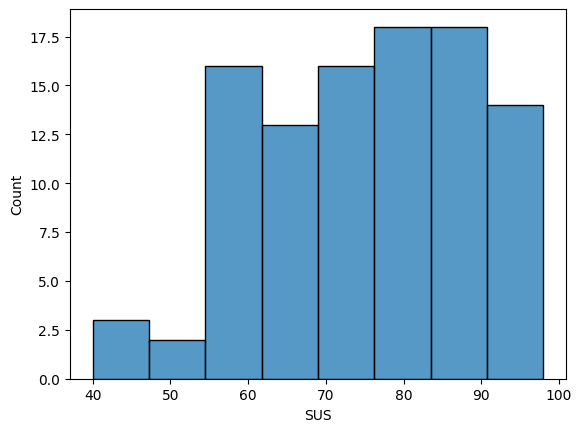

In [179]:
#look at distribution of SUS
sns.histplot(data=df['SUS'], palette='bright')
plt.show()

most SUS scores are above 68 which is considered above average

#### Graphing the Moderate Correlation Variables wrt SUS

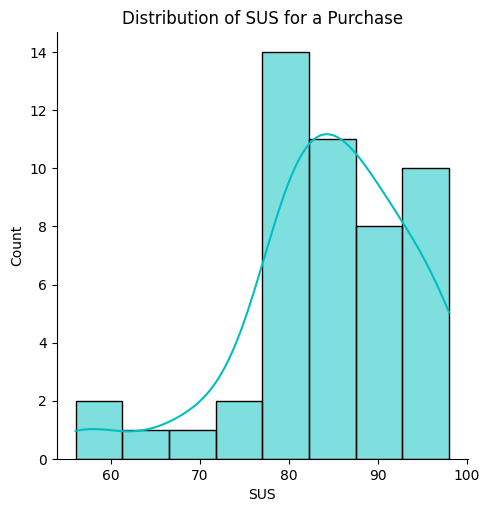

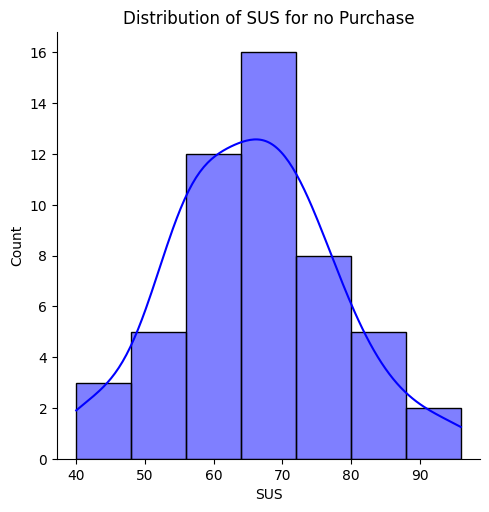

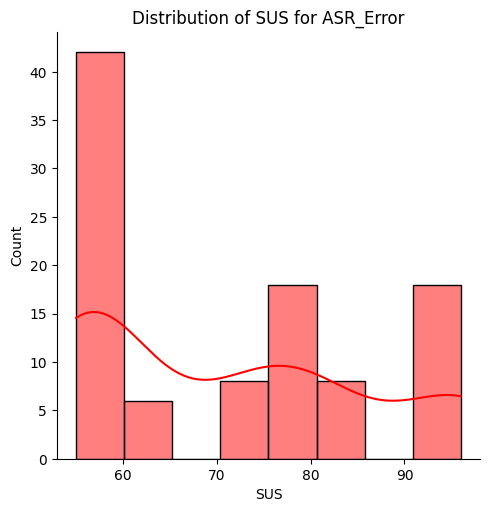

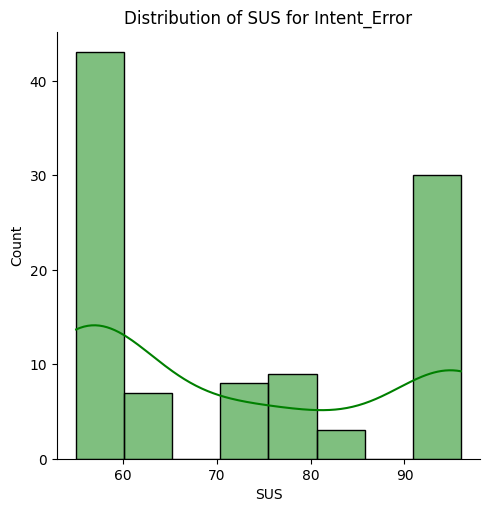

In [181]:
#distrib of both SUS and Purchase
sns.displot(df.loc[df['Purchase'] == 1]['SUS'], color='c', kde=True).set(title='Distribution of SUS for a Purchase')

sns.displot(df.loc[df['Purchase'] == 0]['SUS'], color='b', kde=True).set(title='Distribution of SUS for no Purchase')

#distrib of both SUS and ASR_Error
sns.displot(df.loc[df['ASR_Error']]['SUS'], color='r', kde=True).set(title='Distribution of SUS for ASR_Error')

#distrib of both SUS and Intent_Error
sns.displot(df.loc[df['Intent_Error']]['SUS'], color='g', kde=True).set(title='Distribution of SUS for Intent_Error')


In [182]:
#Ordinary Least Squares Regression 
# allows us to find the significant variables to predict SUS

y = df['SUS'] # dependent variable
x = df.drop(columns='SUS') # predictor variables

#add constant to predictor variables
x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    SUS   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     27.39
Date:                Mon, 13 Feb 2023   Prob (F-statistic):           5.25e-17
Time:                        16:30:21   Log-Likelihood:                -362.39
No. Observations:                 100   AIC:                             736.8
Df Residuals:                      94   BIC:                             752.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           93.0282      5.541     16.788   

only ASR_Error and Intent_Error are statistically significant in changing SUS (Y)

the R^2 score here is 0.593 . which means that 59.3% of our dependent variables (SUS) can be explained using our independent variables 

The F-Test is 27.39 and F-test prob is 5.25e-17. which means there is an extremely small probability that a simpler model could perform with a higher F-statistic

Coef – if X rises 1 unit, how much does Y rise?
-	We can see that is purchase rises 1, SUS rises 1.3412
-	When Gender rises 1, SUS rises 0.8367
-	And so on  

t – t farther from 0 => stronger the evidence against the null hypothesis (the corresponding variable is not significant)  

p>|t| - low p => reject null and conclude that variable is statistically significant
-	Only ASR_Error and Intent_Error are statistically significant in changing SUS.


#### Linear Regression Model

In [183]:
#Regression Analysis 

x = df.drop(columns='SUS') #independent var
y = df['SUS'] #dependent var

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)
#parameters of train_test_split (data , label, proportion of test data among whole data set)
#default proportion is .75 train and .25 test

#x_ is all columns except SUS 
#y_ is corresponding SUS values to x_

#so the answer to x_test is y_test. when we predict x_test. we want to compare to y_test

#creating linear regression obj
#fit takes independent and dependent as vars and fills the regression obj with data that describes the relationship
lr = LinearRegression().fit(x_train,y_train)

#using model to predict test and training data
y_train_pred = lr.predict(x_train)
y_test_pred = lr.predict(x_test)


print("The R square score of linear regression model is: ", lr.score(x_test,y_test))

The R square score of linear regression model is:  0.6146880323064479


#### Graphing True vs Predicted values of the testing and training sets using the Linear Regression Model

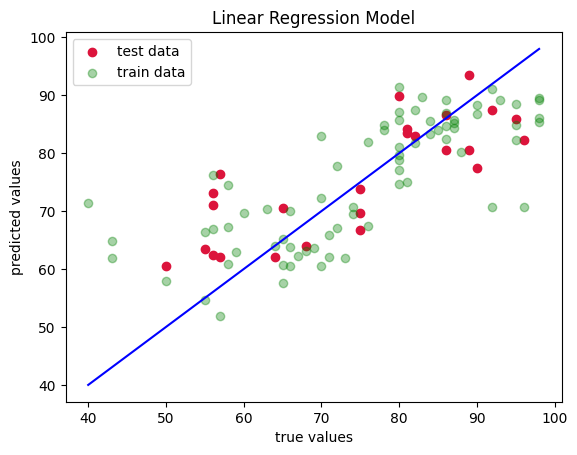

In [111]:
#true vs predicted value
#y_test = true SUS scores
#y_test_pred = predicted test scores from x_test
fig, ax = plt.subplots()
ax.scatter(y_test, y_test_pred, label='test data', color='crimson')
ax.scatter(y_train, y_train_pred, label='train data', color='green', alpha=.35)
p1 = max(max(y_test_pred), max(y_test), max(y_train), max(y_train_pred))
p2 = min(min(y_test_pred), min(y_test), min(y_train), min(y_train_pred))
ax.plot([p1,p2], [p1,p2], color = 'blue')
plt.legend()
plt.title('Linear Regression Model')
plt.xlabel('true values')
plt.ylabel('predicted values')
plt.show()


#### 2-Order Polynomials

In [382]:
quad = PolynomialFeatures (degree = 2)
x_quad = quad.fit_transform(x)

X_train,X_test,Y_train,Y_test = train_test_split(x_quad,y, random_state = 0)

plr = LinearRegression().fit(X_train,Y_train)

Y_train_pred = plr.predict(X_train)
Y_test_pred = plr.predict(X_test)

print("The R square score of 2-order polynomial regression model is: ", plr.score(X_test,Y_test))

The R square score of 2-order polynomial regression model is:  0.522049850343024


#### Graphing True vs Predicted values of the testing and training sets using the 2-Order Polynomial Model

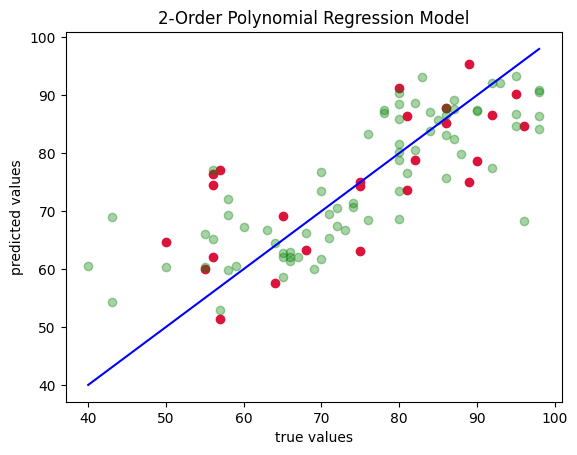

In [383]:
#true vs predicted value
#y_test = true SUS scores
#y_test_pred = predicted test scores from x_test
fig, ax = plt.subplots()
ax.scatter(Y_test, Y_test_pred, label='test data', color='crimson')
ax.scatter(Y_train, Y_train_pred, label='train data', color='green', alpha=.35)
p1 = max(max(Y_test_pred), max(Y_test), max(Y_train), max(Y_train_pred))
p2 = min(min(Y_test_pred), min(Y_test), min(Y_train), min(Y_train_pred))
ax.plot([p1,p2], [p1,p2], color = 'blue')
plt.title('2-Order Polynomial Regression Model')
plt.xlabel('true values')
plt.ylabel('predicted values')
plt.show()

## Section 3: Classification

In [215]:
#Cleaning the data
df = pd.read_csv('data.csv')

df.isna().sum()
new_df = df.fillna(0)

#label
y = new_df['Purchase'].to_numpy()
y

#training data.. all attributes 
X = new_df.drop('Purchase', axis=1)
X = X.drop('SUS', axis=1).to_numpy()
X

array([[254,   0,   3,   2],
       [247,   0,   6,   9],
       [125,   1,   6,   8],
       [ 22,   0,  11,   7],
       [262,   0,   2,   3],
       [113,   1,   8,   9],
       [ 91,   1,   6,   3],
       [ 46,   0,   6,  11],
       [132,   0,   9,   9],
       [190,   0,  11,   4],
       [146,   0,   9,   7],
       [226,   0,   4,   4],
       [ 54,   1,   7,   9],
       [104,   0,   2,   3],
       [292,   0,   7,   3],
       [126,   0,   8,   9],
       [152,   1,   3,   5],
       [221,   0,   3,   4],
       [ 51,   0,   9,   9],
       [230,   0,   6,   8],
       [ 72,   1,   6,   8],
       [284,   0,   6,  11],
       [168,   0,   2,   4],
       [194,   0,   1,   3],
       [130,   1,  10,   1],
       [227,   0,   9,   3],
       [161,   1,   7,   8],
       [262,   1,   2,   3],
       [257,   1,   9,  11],
       [ 57,   1,   8,   3],
       [138,   0,   8,   9],
       [ 33,   1,   9,   4],
       [260,   0,   1,   2],
       [178,   1,   3,   4],
       [153,  

models may produce diff outputs every time data is split in training and testing data

#### Data Scaling and Splitting

In [216]:
#data scaling
#if values are really high compared to other values. this will cause weights to be based on values.
#may cause unstable issues . but scaled will fix that

scale = StandardScaler() #from sklearn
scaled_X = scale.fit_transform(X) #give scaler function input of dataset in order to scale data

#split dataset into training dataset and test dataset
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size = 0.3)
#parameters of train_test_split (data , label, proportion of test data among whole data set)

In [217]:
lc = LogisticRegression()
#neigh = KNeighborsClassifier(n_neighbors=3) #not using this one 
svc = SVC(probability=True)
nbc = GaussianNB() #naive bayes
rfc = RandomForestClassifier()

#### Fitting our 4 models

In [218]:
#train ML model with training dataset 
#these are all different models to train dataset

lc.fit(X_train, y_train) #this trains the model
#lc is initialized logistic regression model 
svc.fit(X_train, y_train)
nbc.fit(X_train, y_train)
rfc.fit(X_train, y_train)

RandomForestClassifier()

#### Testing our 4 models with testing dataset

In [219]:
#testing model with testing dataset

y_lc_predicted = lc.predict(X_test)#predicted results of test dataset
y_lc_pred_proba = lc.predict_proba(X_test)

y_svc_predicted = svc.predict(X_test)
y_svc_pred_proba = svc.predict_proba(X_test)

y_nbc_predicted = nbc.predict(X_test)
y_nbc_pred_proba = nbc.predict_proba(X_test)

y_rfc_predicted = rfc.predict(X_test)
y_rfc_pred_proba = rfc.predict_proba(X_test)

#### Model Evaluation w/ Confusion Matrix and ROC Curve

              precision    recall  f1-score   support

           0       0.87      0.93      0.90        14
           1       0.93      0.88      0.90        16

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30

              precision    recall  f1-score   support

           0       0.87      0.93      0.90        14
           1       0.93      0.88      0.90        16

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30

              precision    recall  f1-score   support

           0       0.82      1.00      0.90        14
           1       1.00      0.81      0.90        16

    accuracy                           0.90        30
   macro avg       0.91      0.91      0.90        30
weighted avg       0.92      0.90      0.90        30

              preci

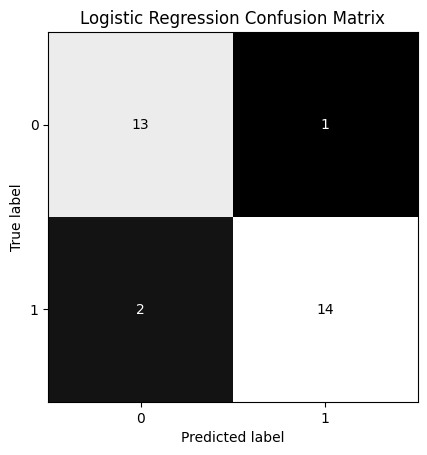

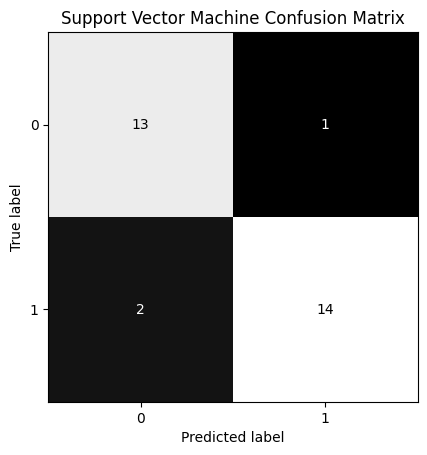

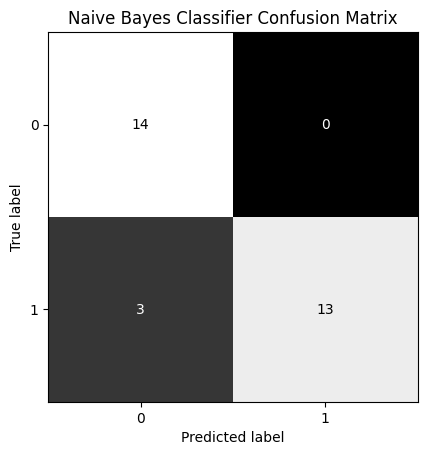

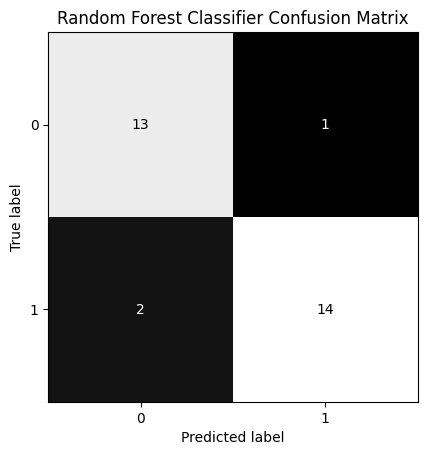

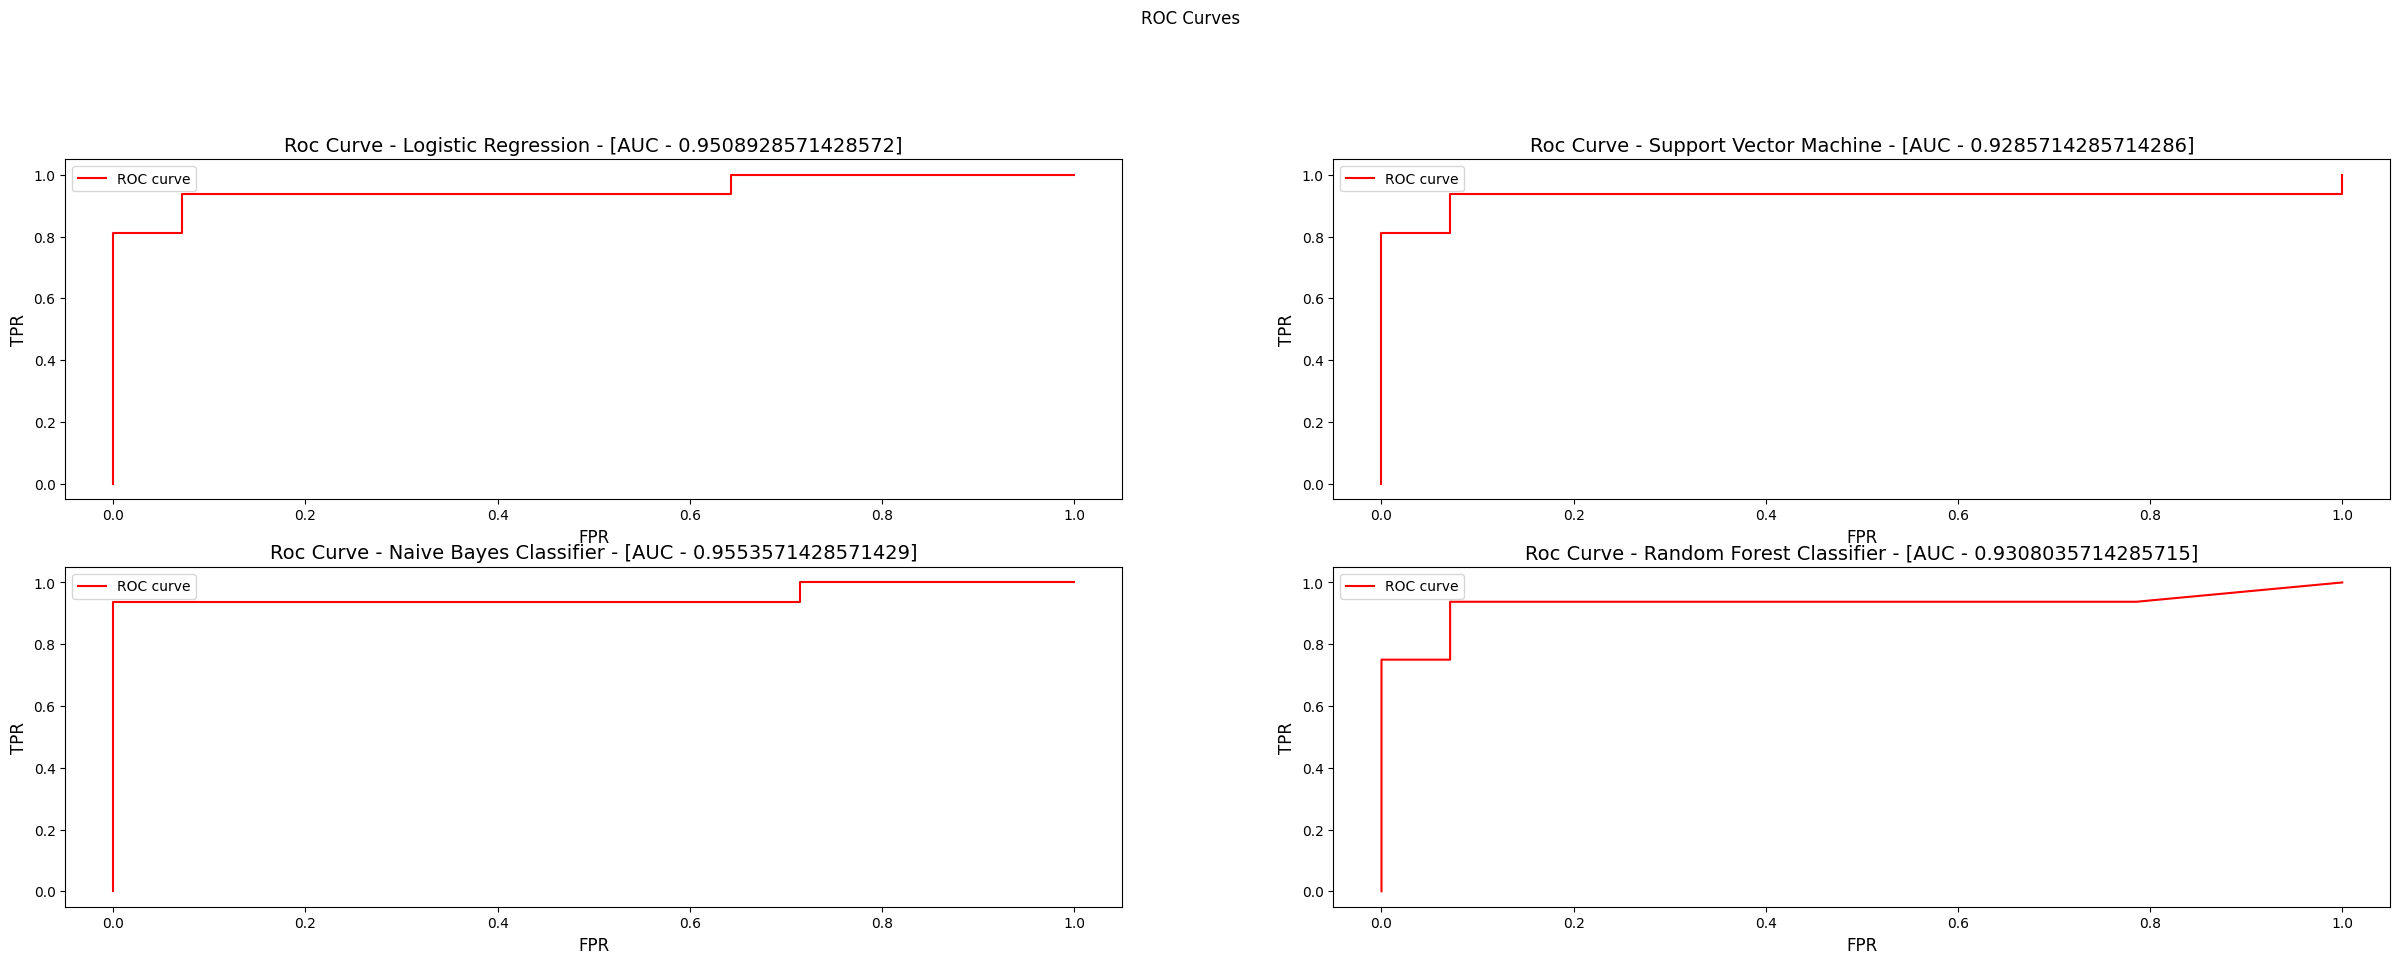

In [220]:
#model evaluation with confusion matrix and ROC curve


print(classification_report(y_test, y_lc_predicted))
#print(classification_report(y_test, y_knn_predicted))
print(classification_report(y_test, y_svc_predicted))
print(classification_report(y_test, y_nbc_predicted))
print(classification_report(y_test, y_rfc_predicted))

models = ['Logistic Regression', 'Support Vector Machine', 'Naive Bayes Classifier', 'Random Forest Classifier']
predictions = [y_lc_predicted, y_svc_predicted, y_nbc_predicted, y_rfc_predicted]
pred_probabilities = [y_lc_pred_proba, y_svc_pred_proba, y_nbc_pred_proba, y_rfc_pred_proba]
#models predictions and probabilities are placed in lists

plot = 1

#creating the confusion matrix for each
for model, prediction, pred_proba in zip(models, predictions, pred_probabilities):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test.ravel(), prediction))
    disp.plot(
        include_values=True,
        cmap='gray',
        colorbar=False
    )
    disp.ax_.set_title(f"{model} Confusion Matrix")

plt.figure(figsize=(30, 15))
plt.suptitle("ROC Curves")
plot_index = 1

#creating the ROC curve graph for each
for model, prediction, pred_proba in zip(models, predictions, pred_probabilities):
    fpr, tpr, thresholds = roc_curve(y_test, pred_proba[:, 1])
    auc_score = auc(fpr, tpr)
    plt.subplot(3, 2, plot_index)
    plt.plot(fpr, tpr, 'r', label='ROC curve')
    # pyplot.figure(figsize=(5, 5))
    plt.title(f'Roc Curve - {model} - [AUC - {auc_score}]', fontsize=14)
    plt.xlabel('FPR', fontsize=12)
    plt.ylabel('TPR', fontsize=12)
    plt.legend()
    plot_index += 1 
plt.show()

accuracy and precision is high for all 4 models  
AUC scores are also very high.  
the Random Forest Model has the highest AUC score making it the best performing model.

### Distribution of Purchase vs No Purchase

C:\Users\avamc_srsebwe\AppData\Local\Temp\ipykernel_15552\2662223677.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=new_df['Purchase'], palette='bright')


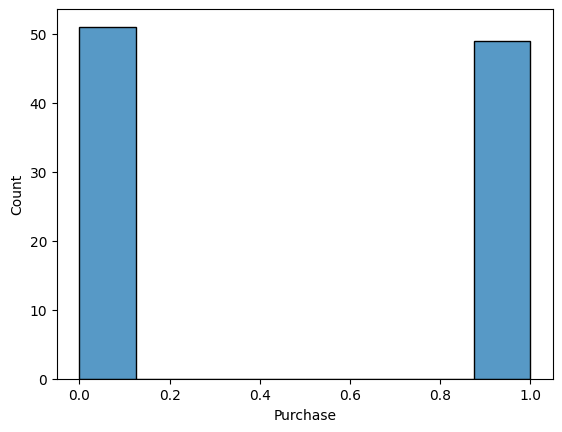

In [211]:
sns.histplot(data=new_df['Purchase'], palette='bright')
plt.show()

#### Since these are evenly distributed classes, we do not need to use SMOTE.

## SMOTE for Imbalanced Classification

### This will produce the same results !

In [212]:
oversample = SMOTE()
over_sampled_X_train, over_sampled_y_train = oversample.fit_resample(X_train, y_train)

lc = LogisticRegression()
#neigh = KNeighborsClassifier(n_neighbors=3)
svc = SVC(probability=True)
nbc = GaussianNB()
rfc = RandomForestClassifier()

lc.fit(over_sampled_X_train, over_sampled_y_train)
#neigh.fit(over_sampled_X_train, over_sampled_y_train)
svc.fit(over_sampled_X_train, over_sampled_y_train)
nbc.fit(over_sampled_X_train, over_sampled_y_train)
rfc.fit(over_sampled_X_train, over_sampled_y_train)

RandomForestClassifier()

In [213]:
y_lc_predicted = lc.predict(X_test)
y_lc_pred_proba = lc.predict_proba(X_test)

# y_knn_predicted = neigh.predict(X_test)
# y_knn_pred_proba = neigh.predict_proba(X_test)

y_svc_predicted = svc.predict(X_test)
y_svc_pred_proba = svc.predict_proba(X_test)

y_nbc_predicted = nbc.predict(X_test)
y_nbc_pred_proba = nbc.predict_proba(X_test)

y_rfc_predicted = rfc.predict(X_test)
y_rfc_pred_proba = rfc.predict_proba(X_test)

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.93      1.00      0.97        14

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        16
           1       0.93      0.93      0.93        14

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        16
           1       0.93      0.93      0.93        14

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30

              preci

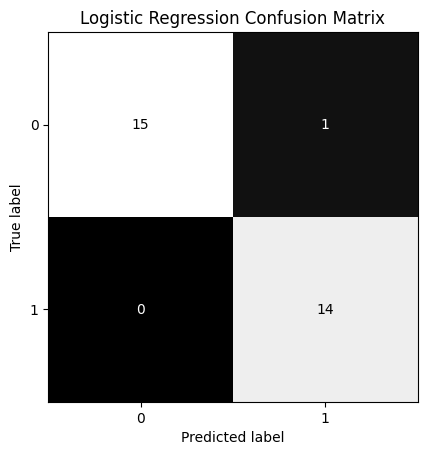

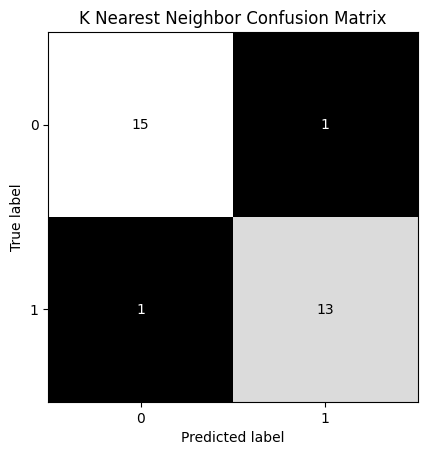

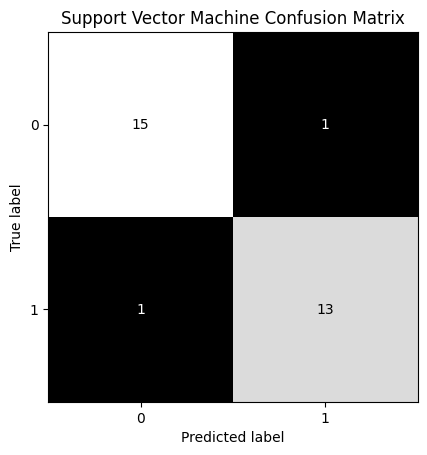

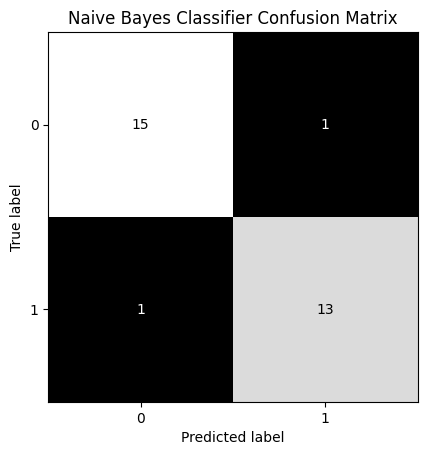

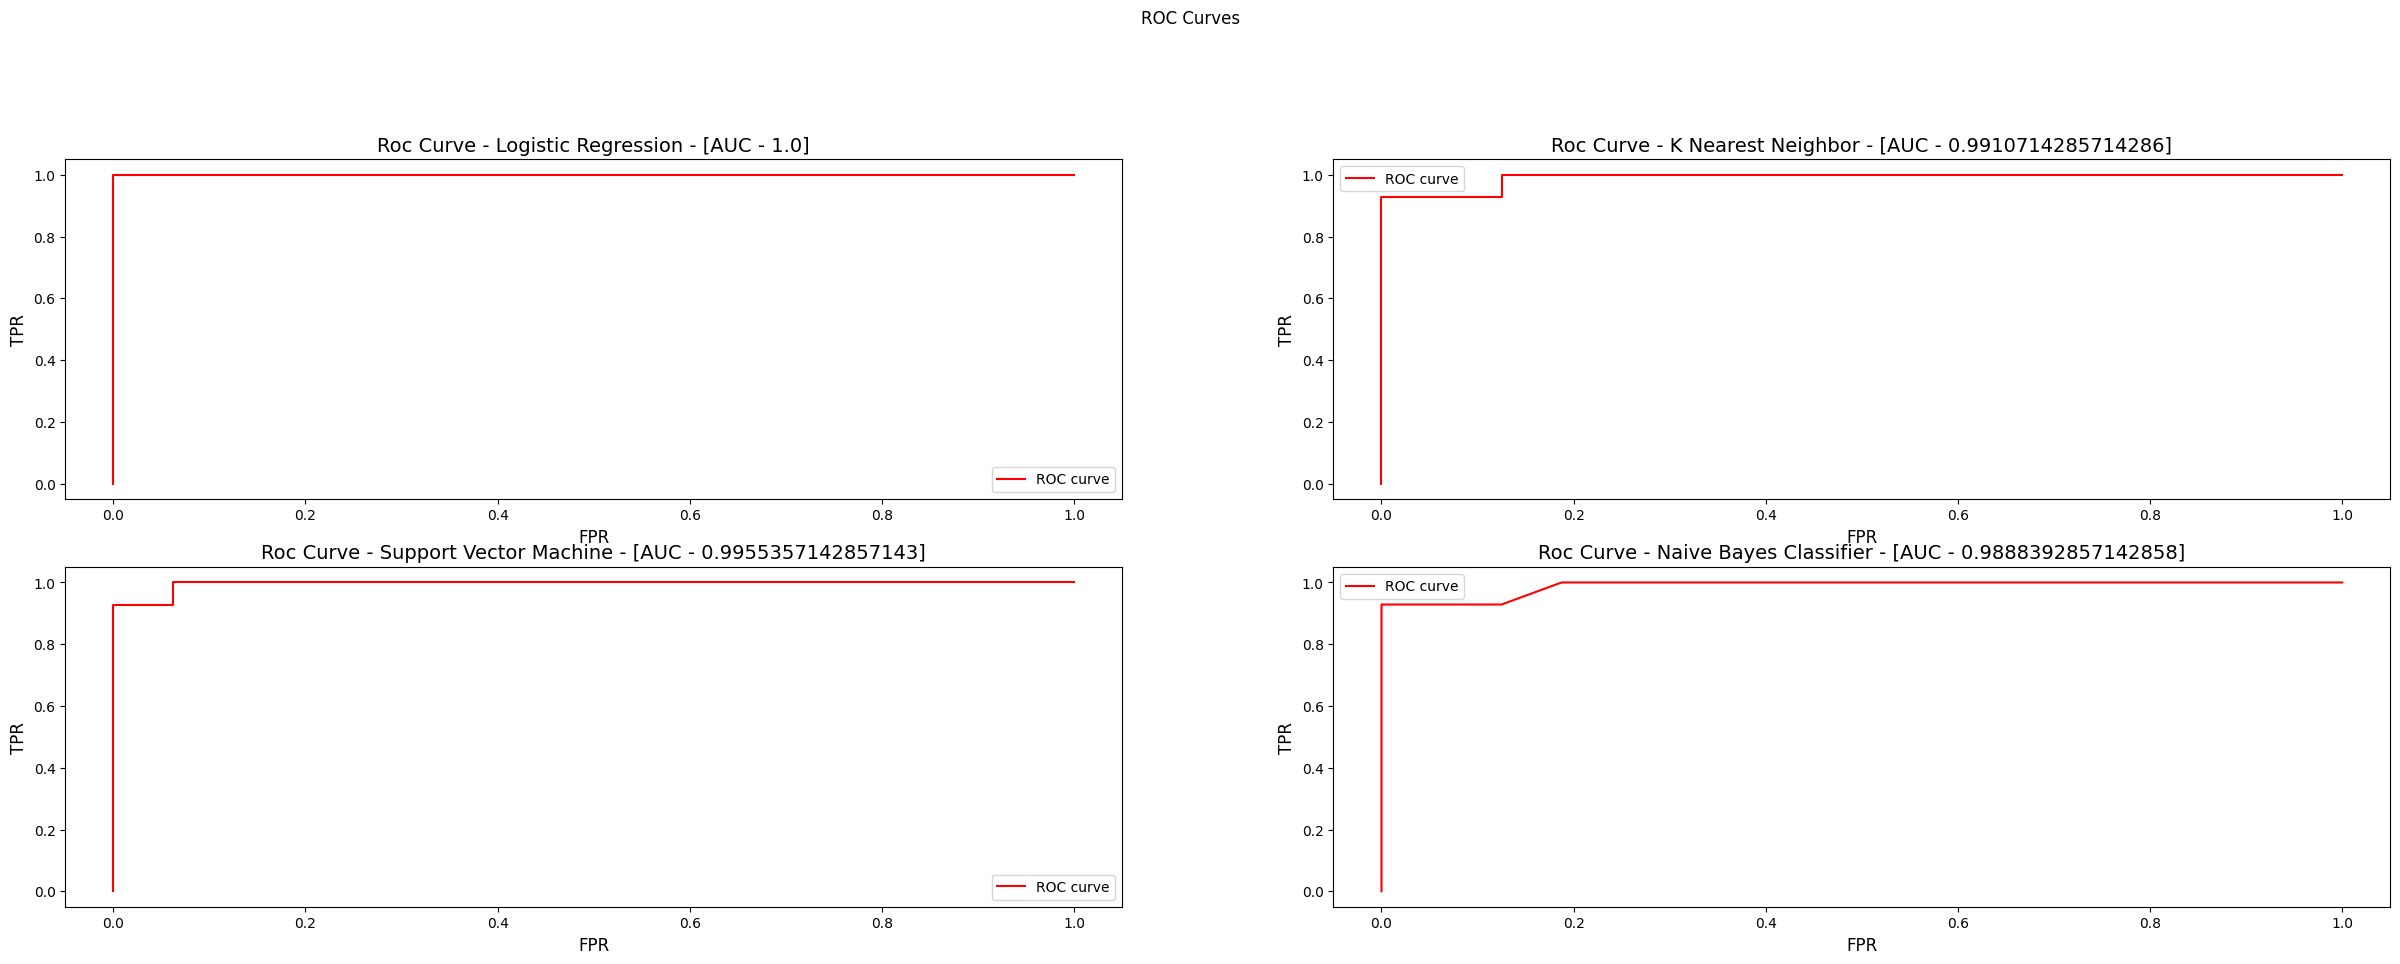

In [214]:
print(classification_report(y_test, y_lc_predicted))
#print(classification_report(y_test, y_knn_predicted))
print(classification_report(y_test, y_svc_predicted))
print(classification_report(y_test, y_nbc_predicted))
print(classification_report(y_test, y_rfc_predicted))

models = ['Logistic Regression', 'K Nearest Neighbor', 'Support Vector Machine', 'Naive Bayes Classifier', 'Random Forest Classifier']
predictions = [y_lc_predicted, y_svc_predicted, y_nbc_predicted, y_rfc_predicted]
pred_probabilities = [y_lc_pred_proba, y_svc_pred_proba, y_nbc_pred_proba, y_rfc_pred_proba]

plot = 1

#printing confusion matrix for each
for model, prediction, pred_proba in zip(models, predictions, pred_probabilities):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test.ravel(), prediction))
    disp.plot(
        include_values=True,
        cmap='gray',
        colorbar=False
    )
    disp.ax_.set_title(f"{model} Confusion Matrix")

plt.figure(figsize=(30, 15))
plt.suptitle("ROC Curves")
plot_index = 1

#printing ROC curve for each
for model, prediction, pred_proba in zip(models, predictions, pred_probabilities):
    fpr, tpr, thresholds = roc_curve(y_test, pred_proba[:, 1])
    auc_score = auc(fpr, tpr)
    plt.subplot(3, 2, plot_index)
    plt.plot(fpr, tpr, 'r', label='ROC curve')
    # pyplot.figure(figsize=(5, 5))
    plt.title(f'Roc Curve - {model} - [AUC - {auc_score}]', fontsize=14)
    plt.xlabel('FPR', fontsize=12)
    plt.ylabel('TPR', fontsize=12)
    plt.legend()
    plot_index += 1
plt.show()